# Recurrent neural network and dynamical system analysis

In this tutorial, we will use supervised learning to train a recurrent neural network on a parametric working memory task, and analyze the trained network using dynamical system analysis.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gyyang/nn-brain/blob/master/ParametricWorkingMemory.ipynb)

## Install dependencies

In [1]:
# # If on Google Colab, uncomment to install neurogym to use cognitive tasks
# ! git clone https://github.com/gyyang/neurogym.git
# %cd neurogym/
# ! pip install -e .

## Defining a cognitive task

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import neurogym as ngym

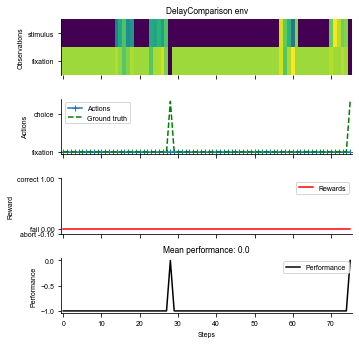

In [3]:
# Environment
task = 'DelayComparison-v0'
timing = {'delay': ('choice', [200, 400, 800, 1600, 3200]),
          'response': ('constant', 500)
         }
kwargs = {'dt': 100, 'timing': timing}
seq_len = 100

# Make supervised dataset
dataset = ngym.Dataset(task, env_kwargs=kwargs, batch_size=16,
                       seq_len=seq_len)

# A sample environment from dataset
env = dataset.env
# Visualize the environment with 2 sample trials
_ = ngym.utils.plot_env(env, num_trials=2, def_act=0)

# Network input and output size
input_size = env.observation_space.shape[0]
output_size = env.action_space.n

In [4]:
inputs, target = dataset()
mask = target > 0
print(inputs.shape)   # (N_time, batch_size, N_neuron)
print(target.shape)   # (N_time, batch_size)

(100, 16, 2)
(100, 16)


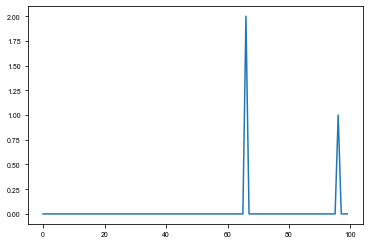

In [5]:
plt.plot(target[:, 0])

## Define a vanilla continuous-time recurrent network

Here we will define a continuous-time neural network but discretize it in time using the Euler method.
\begin{align}
    \tau \frac{d\mathbf{r}}{dt} = -\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r).
\end{align}

This continuous-time system can then be discretized using the Euler method with a time step of $\Delta t$, 
\begin{align}
    \mathbf{r}(t+\Delta t) = \mathbf{r}(t) + \Delta \mathbf{r} = \mathbf{r}(t) + \frac{\Delta t}{\tau}[-\mathbf{r}(t) + f(W_r \mathbf{r}(t) + W_x \mathbf{x}(t) + \mathbf{b}_r)].
\end{align}

In [6]:
# Define networks
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
import math
    

class CTRNN(nn.Module):
    """Continuous-time RNN.

    Args:
        input_size: Number of input neurons
        hidden_size: Number of hidden neurons

    Inputs:
        input: (seq_len, batch, input_size), network input
        hidden: (batch, hidden_size), initial hidden activity
    """

    def __init__(self, input_size, hidden_size, dt=None, **kwargs):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.tau = 100
        if dt is None:
            alpha = 1
        else:
            alpha = dt / self.tau
        self.alpha = alpha
        self.oneminusalpha = 1 - alpha

        self.input2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)

    def init_hidden(self, input_shape):
        batch_size = input_shape[1]
        return torch.zeros(batch_size, self.hidden_size)

    def recurrence(self, input, hidden):
        """Recurrence helper."""
        pre_activation = self.input2h(input) + self.h2h(hidden)
        h_new = torch.relu(hidden * self.oneminusalpha +
                           pre_activation * self.alpha)
        return h_new

    def forward(self, input, hidden=None):
        """Propogate input through the network."""
        if hidden is None:
            hidden = self.init_hidden(input.shape).to(input.device)

        output = []
        steps = range(input.size(0))
        for i in steps:
            hidden = self.recurrence(input[i], hidden)
            output.append(hidden)

        output = torch.stack(output, dim=0)
        return output, hidden


class RNNNet(nn.Module):
    """Recurrent network model.

    Args:
        input_size: int, input size
        hidden_size: int, hidden size
        output_size: int, output size
        rnn: str, type of RNN, lstm, rnn, ctrnn, or eirnn
    """
    def __init__(self, input_size, hidden_size, output_size, **kwargs):
        super().__init__()

        # Continuous time RNN
        self.rnn = CTRNN(input_size, hidden_size, **kwargs)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        rnn_activity, _ = self.rnn(x)
        out = self.fc(rnn_activity)
        return out, rnn_activity

## Train the recurrent network on the decision-making task

In [7]:
import torch.optim as optim

# Instantiate the network and print information
hidden_size = 64
net = RNNNet(input_size=input_size, hidden_size=hidden_size,
             output_size=output_size, dt=env.dt)
print(net)

# Use Adam optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

running_loss = 0
running_acc = 0
for i in range(2000):
    inputs, labels_np = dataset()
    labels_np = labels_np.flatten()
    inputs = torch.from_numpy(inputs).type(torch.float)
    labels = torch.from_numpy(labels_np).type(torch.long)

    # in your training loop:
    optimizer.zero_grad()   # zero the gradient buffers
    output, _ = net(inputs)
    output = output.view(-1, output_size)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    # Compute performance
    output_np = np.argmax(output.detach().numpy(), axis=-1)
    ind = labels_np > 0  # Only analyze time points when target is not fixation
    running_acc += np.mean(labels_np[ind] == output_np[ind])
    if i % 100 == 99:
        running_loss /= 100
        running_acc /= 100
        print('Step {}, Loss {:0.4f}, Acc {:0.3f}'.format(i+1, running_loss, running_acc))
        running_loss = 0
        running_acc = 0

RNNNet(
  (rnn): CTRNN(
    (input2h): Linear(in_features=2, out_features=64, bias=True)
    (h2h): Linear(in_features=64, out_features=64, bias=True)
  )
  (fc): Linear(in_features=64, out_features=3, bias=True)
)
Step 100, Loss 0.2606, Acc 0.049
Step 200, Loss 0.0488, Acc 0.134
Step 300, Loss 0.0268, Acc 0.543
Step 400, Loss 0.0197, Acc 0.728
Step 500, Loss 0.0147, Acc 0.803
Step 600, Loss 0.0113, Acc 0.839
Step 700, Loss 0.0109, Acc 0.823
Step 800, Loss 0.0079, Acc 0.878
Step 900, Loss 0.0082, Acc 0.866
Step 1000, Loss 0.0077, Acc 0.872
Step 1100, Loss 0.0071, Acc 0.878
Step 1200, Loss 0.0063, Acc 0.895
Step 1300, Loss 0.0063, Acc 0.897
Step 1400, Loss 0.0061, Acc 0.897
Step 1500, Loss 0.0070, Acc 0.877
Step 1600, Loss 0.0050, Acc 0.918
Step 1700, Loss 0.0055, Acc 0.907
Step 1800, Loss 0.0056, Acc 0.899
Step 1900, Loss 0.0054, Acc 0.904
Step 2000, Loss 0.0056, Acc 0.899


## Visualize neural activity for in sample trials

We will run the network for 100 sample trials, then visual the neural activity trajectories in a PCA space.

In [8]:
import numpy as np
import gym

# Set delay to 3000ms for analysis
kwargs = {'timing': {'delay': ('constant', 3000)}}
env = gym.make(task, **kwargs)
env.reset(no_step=True)
env.timing

perf = 0
num_trial = 100
activity_dict = {}
trial_infos = {}
for i in range(num_trial):
    env.new_trial()
    ob, gt = env.ob, env.gt
    inputs = torch.from_numpy(ob[:, np.newaxis, :]).type(torch.float)
    action_pred, rnn_activity = net(inputs)
    rnn_activity = rnn_activity[:, 0, :].detach().numpy()
    activity_dict[i] = rnn_activity[env.start_ind['delay']:env.end_ind['delay']]
    trial_infos[i] = env.trial.copy()

# Concatenate activity for PCA
activity = np.concatenate(list(activity_dict[i] for i in range(num_trial)), axis=0)
print('Shape of the neural activity: (Time points, Neurons): ', activity.shape)

# Print trial informations
for i in range(5):
    print('Trial ', i, trial_infos[i])

Shape of the neural activity: (Time points, Neurons):  (3000, 64)
Trial  0 {'ground_truth': 2, 'fpair': (22, 14), 'f1': 14, 'f2': 22}
Trial  1 {'ground_truth': 2, 'fpair': (26, 18), 'f1': 18, 'f2': 26}
Trial  2 {'ground_truth': 1, 'fpair': (30, 22), 'f1': 30, 'f2': 22}
Trial  3 {'ground_truth': 1, 'fpair': (34, 26), 'f1': 34, 'f2': 26}
Trial  4 {'ground_truth': 1, 'fpair': (34, 26), 'f1': 34, 'f2': 26}


In [9]:
# Compute PCA and visualize
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(activity)
# print('Shape of the projected activity: (Time points, PCs): ', activity_pc.shape)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Transform individual trials and Visualize in PC space based on ground-truth color. We see that the neural activity is organized by stimulus ground-truth in PC1

Text(0, 0.5, 'PC 2')

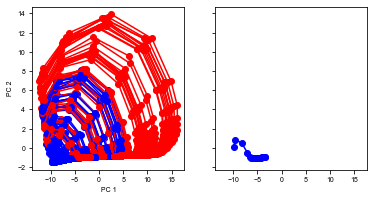

In [10]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, sharex=True, figsize=(6, 3))
for i in range(num_trial):
    trial = trial_infos[i]
    activity_pc = pca.transform(activity_dict[i])
    
    color = 'red' if trial['ground_truth'] == 1 else 'blue'
    
    _ = ax1.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)
    
    if i < 1:
        _ = ax2.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-', color=color)

ax1.set_xlabel('PC 1')
ax1.set_ylabel('PC 2')

## Dynamical system analysis

### Search for approximate fixed points
Here we search for approximate fixed points and visualize them in the same PC space. In a generic dynamical system,
\begin{align}
    \frac{d\mathbf{x}}{dt} = F(\mathbf{x}),
\end{align}
We can search for fixed points by doing the optimization
\begin{align}
    \mathrm{argmin}_{\mathbf{x}} |F(\mathbf{x})|^2.
\end{align}

In [11]:
activity.shape

(3000, 64)

In [12]:
# Freeze for parameters in the recurrent network
for param in net.parameters():
    param.requires_grad = False

batch_size = 64

# Inputs should be the 0-coherence mean input during stimulus period
# This will be task-specific
input = np.tile([1, 0], (batch_size, 1))
input = torch.tensor(input, dtype=torch.float32)

# Here hidden activity is the variable to be optimized
# Initialized randomly for search in parallel (activity all positive)
# hidden_init = np.random.rand(batch_size, hidden_size)*3
hidden_init = activity[np.random.randint(activity.shape[0], size=(batch_size,))]
hidden_init = np.random.uniform(0.5, 1.5, size=hidden_init.shape) * hidden_init
hidden = torch.tensor(hidden_init, requires_grad=True, dtype=torch.float32)

# Use Adam optimizer
optimizer = optim.Adam([hidden], lr=0.01)
criterion = nn.MSELoss()

running_loss = 0
for i in range(10000):
    optimizer.zero_grad()   # zero the gradient buffers
    
    # Take the one-step recurrent function from the trained network
    new_h = net.rnn.recurrence(input, hidden)
    loss = criterion(new_h, hidden)
    loss.backward()
    optimizer.step()    # Does the update

    running_loss += loss.item()
    if i % 1000 == 999:
        running_loss /= 1000
        print('Step {}, Loss {:0.4f}'.format(i+1, running_loss))
        running_loss = 0

Step 1000, Loss 0.0553
Step 2000, Loss 0.0021
Step 3000, Loss 0.0008
Step 4000, Loss 0.0003
Step 5000, Loss 0.0001
Step 6000, Loss 0.0001
Step 7000, Loss 0.0001
Step 8000, Loss 0.0000
Step 9000, Loss 0.0000
Step 10000, Loss 0.0000


### Visualize the found approximate fixed points.

We see that they found an approximate line attrator, corresponding to our PC1, along which evidence is integrated during the stimulus period.

(64, 64)


Text(0, 0.5, 'PC 2')

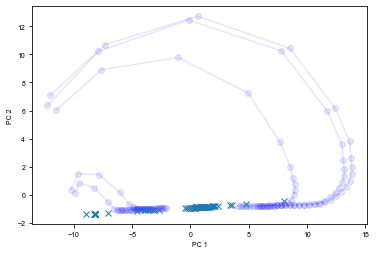

In [13]:
fixedpoints = hidden.detach().numpy()
print(fixedpoints.shape)

# Plot in the same space as activity
plt.figure()
for i in range(5):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
             color=color, alpha=0.1)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x')

plt.xlabel('PC 1')
plt.ylabel('PC 2')

### Computing the Jacobian and finding the line attractor

First we will compute the Jacobian.

In [14]:
# index of fixed point to focus on
# choose one close to center by sorting PC1
i_fp = np.argsort(fixedpoints[:, 0])[int(fixedpoints.shape[0]/2)]

fp = torch.from_numpy(fixedpoints[i_fp])
fp.requires_grad = True

# Inputs should be the 0-coherence mean input during stimulus period
# This will be task-specific
input = torch.tensor([1, 0], dtype=torch.float32)
deltah = net.rnn.recurrence(input, fp) - fp

jacT = torch.zeros(hidden_size, hidden_size)
for i in range(hidden_size):                                                                                                                     
    output = torch.zeros(hidden_size)                                                                                                          
    output[i] = 1.                                                                                                                     
    jacT[:,i] = torch.autograd.grad(deltah, fp, grad_outputs=output, retain_graph=True)[0]
    
jac = jacT.detach().numpy().T

Here we plot the direction of the eigenvector corresponding to the highest eigenvalue

Text(0, 0.5, 'PC 2')

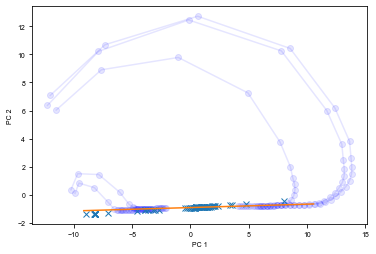

In [15]:
eigval, eigvec = np.linalg.eig(jac)
vec = np.real(eigvec[:, np.argmax(eigval)])
end_pts = np.array([+vec, -vec]) * 10
end_pts = pca.transform(fp.detach().numpy() + end_pts)

# Plot in the same space as activity
plt.figure()
for i in range(5):
    activity_pc = pca.transform(activity_dict[i])
    trial = trial_infos[i]
    color = 'red' if trial['ground_truth'] == 0 else 'blue'
    plt.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
             color=color, alpha=0.1)

# Fixed points are shown in cross
fixedpoints_pc = pca.transform(fixedpoints)
plt.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x')

# Line attractor
plt.plot(end_pts[:, 0], end_pts[:, 1])

plt.xlabel('PC 1')
plt.ylabel('PC 2')

Text(0, 0.5, 'Imaginary')

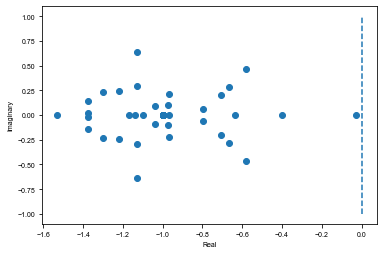

In [16]:
# Plot distribution of eigenvalues in a 2-d real-imaginary plot
plt.figure()
plt.scatter(np.real(eigval), np.imag(eigval))
plt.plot([0, 0], [-1, 1], '--')
plt.xlabel('Real')
plt.ylabel('Imaginary')

# Supplementary Materials

Code for making publication quality figures as it appears in the paper.

In [17]:
# Convert information into pandas dataframe
import pandas as pd
df = pd.DataFrame()
for i in range(len(trial_infos)):
    df = df.append(trial_infos[i], ignore_index=True)
# Example selection of conditions
# print(df[df['f1']==22])

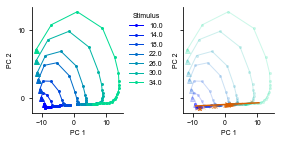

In [18]:
import matplotlib as mpl
plot_fp = True

# Plot in the same space as activity
# fig = plt.figure(figsize=(3, 3))
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(4, 2))

for i in range(2):
    ax = axes[i]
    plot_fp = i == 1
#     ax = fig.add_axes([0.2, 0.2, 0.6, 0.6])

    colors = np.array([[27,158,119], [117,112,179], [217,95,2]])/255.

    # Search for two trials with similar conditions
    values = np.unique(df['f1'])

    color_intensity = [0.4, 0.7, 1.0, 1.3]
    cmap = mpl.cm.get_cmap('winter')
    if plot_fp:
        alpha = 0.2
    else:
        alpha = 1.0
    for i, val in enumerate(values):
        trials = df[df['f1']==val].index
        activity = np.mean(np.array([activity_dict[i] for i in trials]), axis=0)

        activity_pc = pca.transform(activity)
        label = '{:0.1f}'.format(val)
        color = cmap(i/len(values))
        ax.plot(activity_pc[:, 0], activity_pc[:, 1], 'o-',
                 color=color, ms=3, markeredgecolor='none',
                 lw=1, label=label, alpha=alpha)
        ax.plot(activity_pc[0, 0], activity_pc[0, 1], 'o-', alpha=alpha,
                marker='^', color=color, ms=5)

    if plot_fp:
        # Fixed points are shown in cross
        color = colors[2]
        fixedpoints_pc = pca.transform(fixedpoints)
        ax.plot(fixedpoints_pc[:, 0], fixedpoints_pc[:, 1], 'x', ms=3, color=color, alpha=0.3)

        # Line attractor
        ax.plot(fixedpoints_pc[i_fp, 0], fixedpoints_pc[i_fp, 1], 'x', ms=5, color=color, lw=1)
        ax.plot(end_pts[:, 0], end_pts[:, 1], color=color)
    else:
        ax.legend(title='Stimulus', loc='upper left', bbox_to_anchor=(1.0, 1.0), frameon=False)


    ax.set_xlabel('PC 1', fontsize=7)
    ax.set_ylabel('PC 2', fontsize=7)

    # plt.xlim([-5, 5])
    # plt.ylim([-1, 5])

    # Beautification
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_position(('data', -5))
    # ax.spines['bottom'].set_position(('data', -1.5))
plt.tight_layout()
plt.locator_params(nbins=2)
from pathlib import Path
# if plot_fp:
#     fname = Path('figures/lineattractors_parametricWM')
# else:
#     fname = Path('figures/rnndynamics_parametricWM')
fname = Path('figures/rnndynamics_parametricWM')
fig.savefig(fname.with_suffix('.pdf'), transparent=True)
fig.savefig(fname.with_suffix('.png'), dpi=300)